In [1]:
#  模块导入
import numpy as np # numpy 数组
import pandas as pd # pandas 数据框
import openpyxl # 用来打开xlsx文件的引擎
from sklearn.cluster import KMeans # Kmeans聚类
import matplotlib.pyplot as plt # 数据可视化
from collections import Counter # 计数器
import matplotlib.font_manager as mfm # 设置字体
import math # 数学
import json # json
from fastnode2vec import Graph, Node2Vec # deepwalk/node2vec
'''
deepwalk/node2vec
pip install fastnode2vec
https://pypi.org/project/fastnode2vec/0.0.5/
因为这个包是针对旧版gensim写的，所以在安装完后可能需要进入fastnode2vec/node2vec.py，
将27~35行的
super().__init__(
            sg=1,
            iter=1,
            size=dim,
            window=context,
            min_count=1,
            workers=workers,
            batch_words=batch_words,
            **args,
        )
改为
super().__init__(
            sg=1,
            epochs=1, # 这里需要修改变量名
            vector_size=dim, # 这里需要修改变量名
            window=context,
            min_count=1,
            workers=workers,
            batch_words=batch_words,
            **args,
        )
这是因为gensim包在升级的过程中将Word2Vec的API进行了调整。
'''
pass
from sklearn import metrics # 计算指标
import torch # pytorch 深度学习框架
import torch.nn as nn # 神经网络层
import torch.nn.functional as F # 常用函数
import dgl # 图神经网络框架
import matplotlib.pyplot as plt # 数据可视化
from sklearn.metrics import auc,roc_curve # 用于计算auc和绘画roc曲线
from collections import defaultdict # 可以让python字典在创建的时候让字典的value默认为某个数据结构
import matplotlib.font_manager as mfm # 设置字体
from sklearn.manifold import TSNE # 高维数据可视化

device = torch.device("cuda:3") # 指定用于训练的GPU
plt.style.use('ggplot') # 可视化使用ggplot风格

In [2]:
# 数据读取
data = pd.read_excel("anime_information_20220416.xlsx",engine="openpyxl") # 1900~2021年的动画
anime_median = data["动画评分"].median() # 计算动画评分的中位数

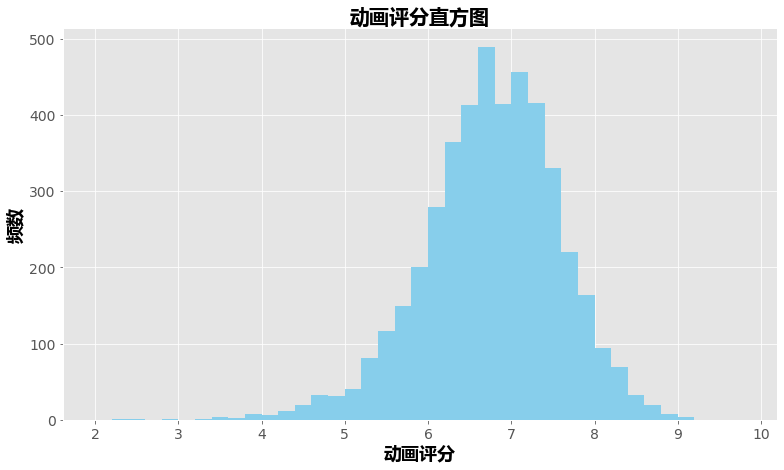

In [3]:
# 绘画1900年~2021年评分的直方图
title_prop = mfm.FontProperties(fname="msyhbd.ttc",size=20) # 指定标题的字体
label_prop = mfm.FontProperties(fname="msyhbd.ttc",size=18) # 指定标签的字体
fig, axes = plt.subplots(1,1, figsize=(12.8,7.2)) # 安排好画布
axes.hist(data["动画评分"],bins=np.arange(2,10,0.2),color="skyblue") # 绘画直方图
plt.xlabel("动画评分",font=label_prop,color="black") # x轴文本
plt.ylabel("频数",font=label_prop,color="black") # y轴文本
plt.xticks(range(2,11),range(2,11),size=14) # x轴刻度设置
plt.yticks(size=14) # y轴刻度设置
plt.title("动画评分直方图",font=title_prop,color="black") # 设置标题
plt.show() # 展示结果

In [4]:
data_new = pd.read_excel("anime_information_2022_from_4_to_9_20220416.xlsx",engine="openpyxl") # 2022年4月~2022年9月的动画
data_new["动画评分"] = anime_median
data = pd.concat([data,data_new]).reset_index(drop=True) # 将两个数据框合并

In [5]:
data.loc[np.where(data["动画名"]=="你的名字。")[0][0],:] # 看一下数据格式

动画ID                                                160209
动画名                                                  你的名字。
动画年份                                                  2016
动画评分                                               7.99982
评分人数                                                 11229
想看人数                                                   509
原作评分                                                     0
导演标准分                                             0.771716
编剧标准分                                             0.771716
原创                                                       1
小说改                                                      0
漫画改                                                      0
游戏改                                                      0
GAL改                                                     0
TV                                                       0
WEB                                                      0
OVA                                                     

In [6]:
def decoder(x):
    # 输入 x 字符串
    # 输出 x 列表
    # 将以一定方法存储的字符串转化为python列表
    if x == '[]':
        return []
    else:
        return x[2:-2].split("\', \'")

In [7]:
data["导演"] = data["导演"].apply(decoder) # 将字符串转化为列表
data["编剧"] = data["编剧"].apply(decoder) # 将字符串转化为列表

In [8]:
staff_work_dict = defaultdict(list) # dict[str(制作人员名),list[str(动画名)]]
for i in range(len(data)):
    for column in ["导演","编剧"]:
        for staff in data[column][i]:
            staff_work_dict[staff].append(data["动画名"][i])

for k,v in staff_work_dict.items():
    staff_work_dict[k] = list(set(v)) # 去重

In [9]:
# 入度归一化
anime_weight = {} # 目标节点为某部动画时，应该具有的权重 dict[str(动画名),int(权重)]
for i in range(len(data)):
    temp_weight = 0
    for column in ["导演","编剧"]:
        for staff in data[column][i]:
            temp_weight += len(staff_work_dict[staff]) - 1
    if temp_weight != 0:
        anime_weight[data["动画名"][i]] = 1 / temp_weight
    else:
        anime_weight[data["动画名"][i]] = 0

In [10]:
anime_edge_dict = {anime:{} for anime in data["动画名"]} # dict[str(源动画名),dict[str(目标动画名),int(权重)]] 存储图以及权重
for i in range(len(data)):
    for column in ["导演","编剧"]:
        for staff in data[column][i]:
            for j in range(len(staff_work_dict[staff])):
                if staff_work_dict[staff][j] != data["动画名"][i]:
                    source_anime = data["动画名"][i]
                    target_anime = staff_work_dict[staff][j]
                    if target_anime not in anime_edge_dict[source_anime]:
                        anime_edge_dict[source_anime][target_anime] = anime_weight[target_anime]
                    else:
                        anime_edge_dict[source_anime][target_anime] += anime_weight[target_anime]
edge_list = []
for k1,v1 in anime_edge_dict.items():
    for k2,v2 in v1.items():
        edge_list.append((k1,k2,v2))
edge_list[0:5]

[('铁扇公主', '大闹天宫', 0.5),
 ('铁扇公主', '人参娃娃', 0.3333333333333333),
 ('神笔', '阿凡提的故事', 0.4),
 ('大闹天宫', '铁扇公主', 1.0),
 ('没头脑和不高兴', '半夜鸡叫', 0.5)]

In [11]:
val_year = 2021 # 确定用于建立验证集的年份
test_year = 2021 # 确定用于建立测试集的年份
predict_year = 2022 # 用于预测的年份

In [12]:
# 设定用于训练，验证，测试的nid
# 比如需要训练的节点是[0,2,3,4,5,...]
train_nids = torch.tensor(np.where(np.logical_and(data["动画年份"] < val_year,data["是否有前作"] == 0))[0],dtype=torch.int32)
val_nids = torch.tensor(np.where(np.logical_and(data["动画年份"] == val_year,data["是否有前作"] == 0))[0],dtype=torch.int32)
test_nids = torch.tensor(np.where(np.logical_and(data["动画年份"] == test_year,data["是否有前作"] == 0))[0],dtype=torch.int32)
final_nids = torch.tensor(np.where(np.logical_and(data["动画年份"] == predict_year,data["是否有前作"] == 0))[0],dtype=torch.int32) # 取2022年4~9月的动画，进行预测

In [13]:
# 把data数据框分成训练集，验证集，测试集数据框
train_data = data.loc[np.where(data["动画年份"] < val_year)[0],:].reset_index(drop=True)
val_data = data.loc[np.where(data["动画年份"] == val_year)[0],:].reset_index(drop=True)
test_data = data.loc[np.where(data["动画年份"] == test_year)[0],:].reset_index(drop=True)

In [14]:
train_tag_set = set() # 训练集标签所组成的集合
for i in range(len(train_data)):
    one_line = train_data["动画标签"][i][2:-2].split("\', \'")
    for tag in one_line:
        train_tag_set.add(tag)
        
test_tag_set = set() # 测试集标签所组成的集合
for i in range(len(test_data)):
    one_line = test_data["动画标签"][i][2:-2].split("\', \'")
    for tag in one_line:
        test_tag_set.add(tag)

hot_style_list = [] # 热门标签的列表

with open("need_style_list_supplement.txt","r",encoding="utf-8") as f: # 从外部引入1000个动画热门标签
    length = int(f.readline().strip())
    for i in range(length):
        hot_style_list.append(f.readline().strip())
        
def judge(style): # 过滤器，目的是将首个字符为数字的标签删除，因为首字符为数字的标签往往标记的是年份
    judge = True
    number_set = set(["0","1","2","3","4","5","6","7","8","9"])
    if len(style)>0:
        if style[0] in number_set:
            judge = False
    return judge
        
tag_set = set() # 最终选择的标签的集合
for tag in test_tag_set:
    if tag in train_tag_set and judge(tag) == True:
        tag_set.add(tag)
        
for tag in hot_style_list:
    if tag in train_tag_set and judge(tag) == True:
        tag_set.add(tag)

In [15]:
# 完成"句子"的生成
sentences = [] # list[list[str(标签)]]
for i in range(len(data)):
    sentences.append([])
    one_line = data["动画标签"][i][2:-2].split("\', \'")
    for tag in one_line:
        if tag in tag_set:
            sentences[i].append(tag)

tag_unique_list = list(tag_set) # 集合转列表
tag2id = {tag_unique_list[i]:i for i in range(len(tag_unique_list))} # 需要考虑的标签 -> id
id2tag = {i:tag_unique_list[i] for i in range(len(tag_unique_list))} # id -> 需要考虑的标签
print("标签的总数量: %d"%(len(tag_unique_list)))

标签的总数量: 1584


In [16]:
sentences[0:2]

[['国产', '剧场版', '电影', '童年', '动画电影', '幻想', '短片', '动画', '国产动画'],
 ['国产',
  '上海美术电影制片厂',
  '童年',
  '短片',
  '剧场版',
  '国产动画',
  '动画',
  '中国',
  '定格动画',
  '剧场',
  '奇幻']]

In [17]:
# 初始化标签的0-1矩阵
tag_matrix = [[0 for _ in range(len(tag_unique_list))] for i in range(len(data))]
for i in range(len(sentences)):
    for tag in sentences[i]:
        tag_matrix[i][tag2id[tag]] = 1
tag_matrix = np.array(tag_matrix,dtype=np.int32)
feature_matrix = np.concatenate((data[["原作评分","导演标准分","编剧标准分","前作评分","是否有前作"]].values,tag_matrix),axis=1)

In [18]:
print("特征的总维度: %d"%(feature_matrix.shape[1]))

特征的总维度: 1589


In [19]:
anime2id = {data["动画名"][i]:i for i in range(len(data))} # 动画名 -> id
id2anime = {i:data["动画名"][i] for i in range(len(data))} # id -> 动画名

In [20]:
# 准备图
edge_list_source = []
edge_list_target = []
for edge in edge_list:
    if data["动画年份"][anime2id[edge[0]]] < data["动画年份"][anime2id[edge[1]]]:
        edge_list_source.append(anime2id[edge[0]])
        edge_list_target.append(anime2id[edge[1]])
edge_list_source = torch.tensor(edge_list_source,dtype=torch.int32)
edge_list_target = torch.tensor(edge_list_target,dtype=torch.int32)

g = dgl.graph((edge_list_source,edge_list_target),num_nodes=len(data),idtype=torch.int32)
'''
edge_list_source : 边从哪个节点来
edge_list_target : 边到哪个节点去
num_nodes : 总节点数
idtype : 指定存储id使用的精度，这里采用int32
'''
g = dgl.add_self_loop(g) # 添加自连边
g.ndata["features"] = torch.tensor(feature_matrix,dtype=torch.float32) # 添加节点的特征，节点数量*特征数量的tensor
g.ndata["y"] = torch.tensor([1 if data["动画评分"][i] > anime_median else 0 for i in range(len(data))],dtype=torch.float32) # 添加节点的y（预测目标）
g.ndata["nid"] = torch.tensor([i for i in range(len(data))],dtype=torch.int32) # 添加节点的nid（其实不一定要有），只是为了方便

In [21]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1) # 确定图的采样方法，这里的方法是采样一层图的所有邻居
train_dataloader = dgl.dataloading.DataLoader( # dataloader
    g, # 图
    train_nids,  # 用于训练的结点id
    sampler, # 给采样方法
    batch_size=256, # batch_size，代表以多少个节点为中心开展采样
    shuffle=True, # 每个epoch是否随机排序
    drop_last=False, # 是否丢弃掉最后的节点（剩余节点数量不足batch_size时）
    num_workers=4) # 线程数量

val_dataloader = dgl.dataloading.DataLoader(
    g, 
    val_nids, 
    sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=4)

In [22]:
class Mymodel_onelayer(nn.Module):
    def __init__(self, in_features, hidden_features):
        '''
        in_features: 输入特征的维度
        hidden_features: 
        '''
        super().__init__() # 父类初始化
        self.conv1 = dgl.nn.pytorch.conv.SAGEConv(in_features, hidden_features , "mean",feat_drop=0.5)
        '''
        图神经网络层: GraphSAGE
        每个节点的特征维度从in_features变为hidden_features
        "mean"代表使用平均方法（GraphSAGE中还采用了其他方法，可供尝试）
        feat_drop代表对初始的特征施加dropout的概率
        如果想修改图神经网络层的细节，需要去SAGEConv类里看
        '''
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(hidden_features+in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        '''
        多层线性层，没有什么特别的
        '''

    def forward(self, blocks, x , output_features):
        x = F.relu(self.conv1(blocks[0], x)) # 经过图神经网络层后，加一个激活函数
        x = self.fc(torch.cat((x, output_features),dim=1)).squeeze(1) # 拼接由图神经网络层获得的邻居信息和自身的信息，进行最终的预测
        return x

In [23]:
model = Mymodel_onelayer(feature_matrix.shape[1], feature_matrix.shape[1]).to(device) # 初始化模型，移动到gpu
opt = torch.optim.Adam(model.parameters(),lr=5e-5,weight_decay=0.03) # 设置学习率，正则化参数
best_val_score = 0 # 计算验证集上的最好结果
best_model = None

for epoch in range(300): # 300个epoch
    model.train() # 使模型进入训练状态，启动dropout
    train_loss = 0
    train_predictions = []
    train_labels = []
    for input_nodes, output_nodes, blocks in train_dataloader:
        '''
        input_nodes : 输入的节点的nid, 长度一般比output_nodes长
        output_nodes : 输出的节点的nid，长度等于batch_size
        blocks : 图的列表，具体到这里，其实只给出了一张图，因为我们的图神经网络只有一层
        '''
        blocks = [b.to(device) for b in blocks] # 把图放进GPU
        input_features = blocks[0].srcdata['features'] # 源节点的特征
        output_features = blocks[-1].dstdata['features'] # 目标节点的特征
        output_y = blocks[-1].dstdata['y'] # 存在目标节点上的y
        output_predictions = model(blocks, input_features, output_features) # 计算预测值
        loss = F.binary_cross_entropy(output_predictions, output_y) # loss
        opt.zero_grad() # 优化器梯度清空
        loss.backward() # 反向传播
        opt.step() # 优化
        train_loss += loss.item() * len(output_y)
        train_predictions.append(output_predictions.detach().cpu().numpy())
        train_labels.append(output_y.detach().cpu().numpy())
    train_loss /= len(train_nids)
    train_predictions = np.concatenate(train_predictions)
    train_labels = np.concatenate(train_labels)
    fpr,tpr,threshold = roc_curve(train_labels,train_predictions,pos_label=1) #计算真正率和假正率
    train_score = auc(fpr,tpr) #计算auc的值
    model.eval() # 使模型进入验证状态，关闭dropout
    with torch.no_grad():
        val_loss = 0
        val_predictions = []
        val_labels = []
        for input_nodes, output_nodes, blocks in val_dataloader:
            blocks = [b.to(device) for b in blocks]
            input_features = blocks[0].srcdata['features']
            output_features = blocks[-1].dstdata['features']
            output_y = blocks[-1].dstdata['y']
            output_predictions = model(blocks, input_features, output_features)
            loss = F.binary_cross_entropy(output_predictions, output_y)
            val_loss += loss.item() * len(output_y)
            val_predictions.append(output_predictions.cpu().numpy())
            val_labels.append(output_y.cpu().numpy())
        val_loss /= len(val_nids)
        val_predictions = np.concatenate(val_predictions)
        val_labels = np.concatenate(val_labels)
        fpr,tpr,threshold = roc_curve(val_labels,val_predictions,pos_label=1) #计算真正率和假正率
        val_score = auc(fpr,tpr) #计算auc的值
        if val_score > best_val_score:
            best_val_score = val_score
#             torch.save(model,"best_model")
    if (epoch+1) % 10 == 0:
        print("epoch %d :"%(epoch+1),end=" ")
        print("训练集binary_cross_entropy : %.4f"%(train_loss),end=" ")
        print("训练集auc : %.4f"%(train_score),end=" ")
        print("验证集binary_cross_entropy : %.4f"%(val_loss),end=" ")
        print("验证集auc : %.4f"%(val_score))

epoch 10 : 训练集binary_cross_entropy : 0.6797 训练集auc : 0.7541 验证集binary_cross_entropy : 0.6646 验证集auc : 0.7099
epoch 20 : 训练集binary_cross_entropy : 0.6313 训练集auc : 0.7951 验证集binary_cross_entropy : 0.6114 验证集auc : 0.7249
epoch 30 : 训练集binary_cross_entropy : 0.5637 训练集auc : 0.8117 验证集binary_cross_entropy : 0.5547 验证集auc : 0.7420
epoch 40 : 训练集binary_cross_entropy : 0.5311 训练集auc : 0.8305 验证集binary_cross_entropy : 0.5379 验证集auc : 0.7505
epoch 50 : 训练集binary_cross_entropy : 0.5104 训练集auc : 0.8459 验证集binary_cross_entropy : 0.5320 验证集auc : 0.7540
epoch 60 : 训练集binary_cross_entropy : 0.5023 训练集auc : 0.8489 验证集binary_cross_entropy : 0.5262 验证集auc : 0.7618
epoch 70 : 训练集binary_cross_entropy : 0.4954 训练集auc : 0.8521 验证集binary_cross_entropy : 0.5246 验证集auc : 0.7599
epoch 80 : 训练集binary_cross_entropy : 0.4826 训练集auc : 0.8614 验证集binary_cross_entropy : 0.5217 验证集auc : 0.7636
epoch 90 : 训练集binary_cross_entropy : 0.4834 训练集auc : 0.8588 验证集binary_cross_entropy : 0.5191 验证集auc : 0.7628
epoch 100 : 训练集bina

In [24]:
test_dataloader = dgl.dataloading.DataLoader(
    g, 
    test_nids, 
    sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=4)

In [25]:
# model = torch.load("best_model")

In [26]:
def ROC(y_true,y_pre,model_name):
    fpr,tpr,threshold = roc_curve(y_true,y_pre,pos_label=1) #计算真正率和假正率
    roc_auc = auc(fpr,tpr) #计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC Curve (AUC = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
    plt.yticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=20)
    plt.xlabel('False Positive Rate',fontsize=25)
    plt.ylabel('True Positive Rate',fontsize=25)
    plt.title('ROC curve of {}'.format(model_name),fontsize=25)
    plt.legend(loc="lower right",fontsize=20)
    plt.show()

测试集binary_cross_entropy : 0.5124
测试集auc : 0.7695


<Figure size 432x288 with 0 Axes>

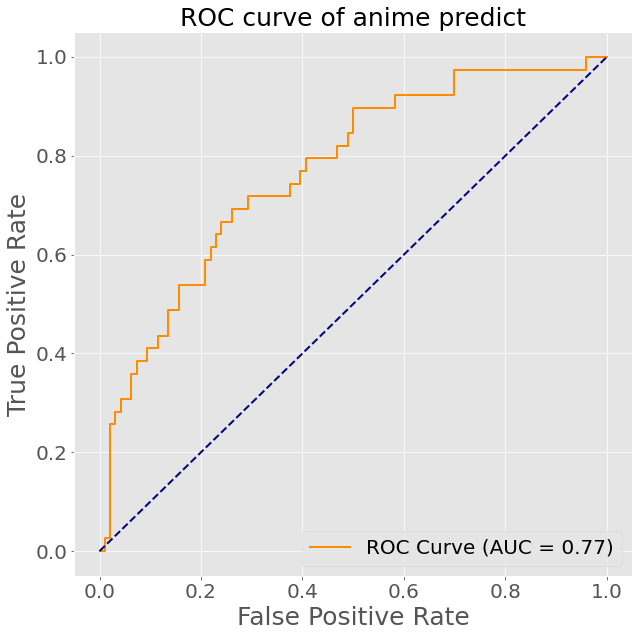

In [27]:
model.eval()
with torch.no_grad():
    test_loss = 0
    test_predictions = []
    test_labels = []
    for input_nodes, output_nodes, blocks in test_dataloader:
        blocks = [b.to(device) for b in blocks]
        input_features = blocks[0].srcdata['features']
        output_features = blocks[-1].dstdata['features']
        output_y = blocks[-1].dstdata['y']
        output_predictions = model(blocks, input_features, output_features)
        loss = F.binary_cross_entropy(output_predictions, output_y)
        test_loss += loss.item() * len(output_y)
        
        test_predictions.append(output_predictions.cpu().numpy())
        test_labels.append(output_y.cpu().numpy())
    test_loss /= len(test_nids)
    test_predictions = np.concatenate(test_predictions)
    test_labels = np.concatenate(test_labels)
    fpr,tpr,threshold = roc_curve(test_labels,test_predictions,pos_label=1) #计算真正率和假正率
    test_score = auc(fpr,tpr) #计算auc的值
    print("测试集binary_cross_entropy : %.4f"%(test_loss))
    print("测试集auc : %.4f"%(test_score))
    ROC(test_labels,test_predictions,"anime predict")

In [28]:
# 2018 0.8466
# 2019 0.8758
# 2020 0.8460
# 2021 0.8377
# 平均 0.8515

In [29]:
final_dataloader = dgl.dataloading.DataLoader(
    g, 
    final_nids, 
    sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=4)
model.eval()
with torch.no_grad():
    final_nid = []
    final_predictions = []
    for input_nodes, output_nodes, blocks in final_dataloader:
        blocks = [b.to(device) for b in blocks]
        input_features = blocks[0].srcdata['features']
        output_features = blocks[-1].dstdata['features']
        output_y = blocks[-1].dstdata['y']
        output_predictions = model(blocks, input_features, output_features)
        loss = F.mse_loss(output_y, output_predictions)
        final_predictions.append(output_predictions.cpu().numpy())
        final_nid.append(output_nodes.cpu().numpy())
    final_predictions = np.concatenate(final_predictions)
    final_nid = np.concatenate(final_nid)
    final_name = [data["动画名"][nid] for nid in final_nid]
    final_raters = [data["想看人数"][nid] for nid in final_nid]
    final_judge = [1 if final_predictions[i] > 0.5 else 0 for i in range(len(final_predictions))]
    final_anime_id = [data["动画ID"][nid] for nid in final_nid]
final_dataframe = pd.DataFrame({"位置":final_nid,"动画名":final_name,"动画ID":final_anime_id,"预测值":final_predictions,"想看人数":final_raters,"判断是否为好片":final_judge})
final_dataframe = final_dataframe.sort_values(by="预测值",ascending=False).reset_index(drop=True)

In [30]:
april_anime = {354246,354682,364686,376215,331946,329285,314366,329906,279321,284510,367727,363880,317613,351973,333176,365297,354700,333664,313852,353906,337459,371892,366253,356763,327606,372925,353266,361697,326895,351943,332585,302128,355072,356756,347140,334498,333624,375772,349465,339998,377421,345705,335579,359980,320238,359527,326871,309092,376676,334203,353657,363242,324295,330055,366780,351714,359930,358571,376673,363959,376674,376666,345868,375918,375813,332446,347818,374807,320236,376670,363414,268449,310263,349443,317042,289906,338653,366897,347953,376675,358754,362997,375987,361384,343656,333448,334319,377133,359589,371822,370427,361280,277369,304727,331489,312437,328197,284524,340677,361385,372317,367726,377811,354630,374002,277037,376147,375739,347888,303126,372472,341657,349442,377273}
july_anime = {331479,375817,368816,375531,293008,338371,324728,375977,364845,330057,192976,371546,356774,375511,335389,349388,354414,349084,357754,298654,326874,355342,345649,375571,366793,298477,371396,354146,364450,253047,366566,286126,377812,315745,352336,262898,339916,303195,365705,339326,322130,348538,326869,316131,373710,368617,358803,343136,286127,317376,356658,332133,312297,331652,368456,365706,345761}

In [31]:
instead_of_dictionary = {} # 同义替换词 被替换词->替换词
with open("instead_of.txt","r",encoding="utf-8") as f:
    line = f.readline()
    while line:
        line = line.strip()
        if line != "":
            temp = line.split("：")
            instead_of_dictionary[temp[0]] = temp[1]
        line = f.readline()

In [32]:
def to_set(x,instead_of_dictionary):
    if x == "[]":
        return set()
    else:
        temp_list = [instead_of_dictionary[tag] if tag in instead_of_dictionary else tag for tag in x[2:-2].split("\', \'")]
        return set(temp_list)
    
def to_list(x,instead_of_dictionary):
    if x == "[]":
        return list()
    else:
        temp_list = [instead_of_dictionary[tag] if tag in instead_of_dictionary else tag for tag in x[2:-2].split("\', \'")]
        return list(set(temp_list))
    
def tag_in_set(x,tag):
    return int(tag in x)

def sort_list(x,future_tag_dict):
    return sorted(x,key=lambda x:future_tag_dict[x]["p_value"])

now_data = data.loc[np.where(data["动画年份"] < predict_year)[0],:].copy()
now_data["动画标签集合"] = now_data["动画标签"].apply(to_set,args=[instead_of_dictionary])

In [33]:
future_data = data.loc[np.where(data["动画年份"] == predict_year)[0],:].copy().reset_index(drop=True)
future_data["动画标签列表"] = future_data["动画标签"].apply(to_list,args=[instead_of_dictionary])
future_tag = list(set([tag for i in range(len(future_data)) for tag in future_data["动画标签列表"][i]]))

In [34]:
import statsmodels.api as sm
future_tag_dict = {tag:{"p_value":1,"coefficient":0} for tag in future_tag}
for tag in future_tag:
    X = now_data["动画标签集合"].apply(tag_in_set,args=[tag])
    X = sm.add_constant(X)
    X.columns = ["const",tag]
    mymodel = sm.OLS(now_data["动画评分"], X)
    results = mymodel.fit()
    if np.isnan(results.pvalues[tag]) == False:
        future_tag_dict[tag]["p_value"] = results.pvalues[tag]
        future_tag_dict[tag]["coefficient"] = results.params[tag]

In [35]:
future_data["动画标签列表"] = future_data["动画标签列表"].apply(sort_list,args=[future_tag_dict])

In [39]:
future_data.index = future_data["动画ID"]
p_value_threshold = 0.01
ban_set = {"动画","日本动画","日本","TV","剧场版","OVA","WEB","未确定","未开播","TVA","待上映","新番","可独立观赏","？","映画","总集篇","追番","动画电影","『TVA』","优先级X","春季番","霸权","动画史上绝无仅有的神作"}
print_anime_count = 0
print("四月TV动画预测：")
for i in range(len(final_dataframe)):
    if (final_dataframe["动画ID"][i] in april_anime and data["TV"][final_dataframe["位置"][i]] == 1) or final_dataframe["动画ID"][i] == 361280:
#     if final_dataframe["动画ID"][i] in april_anime:
        print("Rank {} : ".format(print_anime_count+1))
        print_anime_count += 1
        print(final_dataframe["动画名"][i],end="\n")
        print_tag_count = 0
        for j in range(len(future_data["动画标签列表"][final_dataframe["动画ID"][i]])):
            if print_tag_count >= 5:
                break
            if future_data["动画标签列表"][final_dataframe["动画ID"][i]][j] in ban_set or judge(future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]) == False:
                continue
            print("{}".format(future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]),end="")
            print_tag_count += 1
            if future_tag_dict[future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]]["p_value"] < p_value_threshold:
                if future_tag_dict[future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]]["coefficient"] > 0:
                    print("↑",end=" ")
                else:
                    print("↓",end=" ")
            else:
                print("",end=" ")
        print("\n")

四月TV动画预测：
Rank 1 : 
夏日重现
剧情↑ 漫画改↑ 科幻↑ 智斗↑ 半年番↑ 

Rank 2 : 
间谍过家家
治愈↑ 漫画改↑ 日常↑ 战斗↓ 恋爱 

Rank 3 : 
舞动不止
青春↑ 漫画改↑ 励志↑ 山下大辉↓ 运动↑ 

Rank 4 : 
青之芦苇
漫画改↑ 热血↑ Production.I.G↑ 竞技↑ 运动↑ 

Rank 5 : 
女忍者椿的心事
漫画改↑ 日常↑ 萌 CloverWorks 白户佑辅 

Rank 6 : 
Estab Life Great Escape
科幻↑ 岭内知美↓ 原创 长绳麻理亚 贺东招二 

Rank 7 : 
歌愈少女
治愈↑ 日常↑ 奇幻↓ 木村畅 原创 

Rank 8 : 
社畜小姐想被幽灵幼女治愈。
治愈↑ 漫画改↑ projectNo.9↓ 日常↑ 日高里菜↓ 

Rank 9 : 
身为女主角 讨厌的女主角与秘密的工作
青春↑ 乙女向↓ 日常↑ 岛崎信长↓ honeyworks 

Rank 10 : 
相合之物
治愈↑ 漫画改↑ 日常↑ 吉田玲子↑ 岛崎信长↓ 

Rank 11 : 
朋友游戏
漫画改↑ 智斗↑ 大逃杀 OkurutoNoboru 猪原健太 

Rank 12 : 
RPG不动产
漫画改↑ 异世界↓ 日常↑ 芳文社↑ 奇幻↓ 

Rank 13 : 
遗迹守护者
漫画改↑ 科幻↑ davidproduction 濑古浩司 阿座上洋平 

Rank 14 : 
鬼裤衩
奇幻↓ 萌 原创 偶像 WITSTUDIO 

Rank 15 : 
邪神ちゃんドロップキックXまめアニメ（北海道編）
漫画改↑ 小说改↓ 续作↑ 萌 原创 

Rank 16 : 
Love All Play
青春↑ 励志↑ 竞技↑ 花江夏树↓ 小说改↓ 

Rank 17 : 
测不准的阿波连同学
治愈↑ 漫画改↑ 日常↑ 萌 恋爱 

Rank 18 : 
这个医师超麻烦
漫画改↑ 异世界↓ 战斗↓ 奇幻↓ 佐藤拓也 

Rank 19 : 
BUBBLE
电影↑ 网飞↓ 小畑健↑ 梶裕贵 原创 

Rank 20 : 
黑岩射手 DAWN FALL
科幻↑ 战斗↓ 续作↑ 奇幻↓ 文艺复兴↓ 

Rank 21 : 
莎木
游戏改↓ 战斗↓ 辱华↓ 下山健人 樱井孝宏 

Rank 22 :

In [37]:
print("七月TV动画预测：")
print_anime_count = 0
for i in range(len(final_dataframe)):
    if final_dataframe["动画ID"][i] in july_anime and data["TV"][final_dataframe["位置"][i]] == 1:
        print("Rank {} : ".format(print_anime_count+1))
        print_anime_count += 1
        print(final_dataframe["动画名"][i],end="\n")
        print_tag_count = 0
        for j in range(len(future_data["动画标签列表"][final_dataframe["动画ID"][i]])):
            if print_tag_count >= 5:
                break
            if future_data["动画标签列表"][final_dataframe["动画ID"][i]][j] in ban_set or judge(future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]) == False:
                continue
            print("{}".format(future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]),end="")
            print_tag_count += 1
            if future_tag_dict[future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]]["p_value"] < p_value_threshold:
                if future_tag_dict[future_data["动画标签列表"][final_dataframe["动画ID"][i]][j]]["coefficient"] > 0:
                    print("↑",end=" ")
                else:
                    print("↓",end=" ")
            else:
                print("",end=" ")
        print("\n")

七月TV动画预测：
Rank 1 : 
RWBY 冰雪帝国
科幻↑ SHAFT↑ 冲方丁↑ 日笠阳子 美国原作改编 

Rank 2 : 
夜曲
漫画改↑ 日常↑ LIDENFILMS↓ noitaminA↑ 奇幻↓ 

Rank 3 : 
风都侦探
漫画改↑ 科幻↑ 小野大辅 椛岛洋介 StudioKAI 

Rank 4 : 
组长女儿与照料专员
治愈↑ 漫画改↑ 日常↑ GAINAX↑ 川崎逸朗↓ 

Rank 5 : 
SHINE POST
日常↑ 原创 偶像 及川启 音乐 

Rank 6 : 
光辉魔女
SHAFT↑ 战斗↓ 原创 偶像 未来会看 

Rank 7 : 
异世界叔叔
漫画改↑ 异世界↓ 穿越↓ 小松未可子↓ 福山润 

Rank 8 : 
ユーレイデコ
原创 佐藤大 ScienceSARU 霜山朋久 

Rank 9 : 
Extreme Hearts
日常↑ 运动↑ 原创 冈咲美保 都筑真纪 

Rank 10 : 
幕末替身传说
原创 Genostudio 平川哲生 

Rank 11 : 
リコリス・リコイル
日常↑ 原创 若山诗音 百合 安济知佳 

Rank 12 : 
卡片战斗先导者overDress 第三季
高桥奈津子↓ 苍井翔太↓ 内田雄马↓ KINEMACITRUS 森贤 

Rank 13 : 
就算这样，“步”还是靠了过来
漫画改↑ 日常↑ 三重野瞳↓ SILVERLINK.↓ 小原好美 

Rank 14 : 
金装的维尔梅～濒临堕落的魔法师和最强的灾厄一起冲入魔法世界～
漫画改↑ 异世界↓ 战斗↓ 奇幻↓ 恋爱 

Rank 15 : 
黑之召唤士
异世界↓ 战斗↓ 小说改↓ Satelight↓ 上田丽奈 

Rank 16 : 
顶点!!!!!!!!!!!!!!!
渡部稳宽↓ 原创 职场 高松信司 drive 

Rank 17 : 
转生贤者的异世界生活
异世界↓ 战斗↓ 小说改↓ 奇幻↓ 和气杏未 

Rank 18 : 
Engage Kiss
齐藤壮马↓ 原创 恋爱 Lynn Pictures 

Rank 19 : 
むさしの！
泡面番↓ 濑户麻沙美 A-Real 明坂聪美 渡部惠子 

Rank 20 : 
东方少年 第二季
漫画改↑ 齐藤壮马↓ 内田雄马↓ 柳泽哲也 A.C.G.T 

Rank